# Importando bibliotecas

In [26]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
from sys import stdout
from statsmodels.tsa.arima.model import ARIMA
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import seaborn as sns
from RegscorePy import aic
import warnings
warnings.simplefilter('ignore')
%matplotlib inline
sns.set_style("whitegrid")
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

# 1. Importando base de dados formatada

## 1.1 Tratando os dados internos

In [27]:
dt_parse = lambda dates: dt.strptime(dates, '%Y-%m-%d')

data = pd.read_csv('data/transformed/2000_2021_Brazilian_Northeast_Region_daily_MW_instantaneous_maximum_demand_series.csv',
                   header=0, names=['index','value', 'date'], parse_dates=True, index_col='index', date_parser=dt_parse)
data['value'] = data['value'].astype(float)
data['date'] = data['date'].astype('datetime64')
data = data[data['value'] > 0.0]
data.head()

,value,date
index,,
2000-01-01,6205.0,2000-01-01
2000-01-02,6797.0,2000-01-02
2000-01-03,7024.0,2000-01-03
2000-01-04,6921.0,2000-01-04
2000-01-05,7025.0,2000-01-05


# 2. Autocorrelação

In [28]:
v_log = np.log(data['value'])
v_log_diff = np.diff(v_log)

# 2.1 Autocorreção com os dados originais

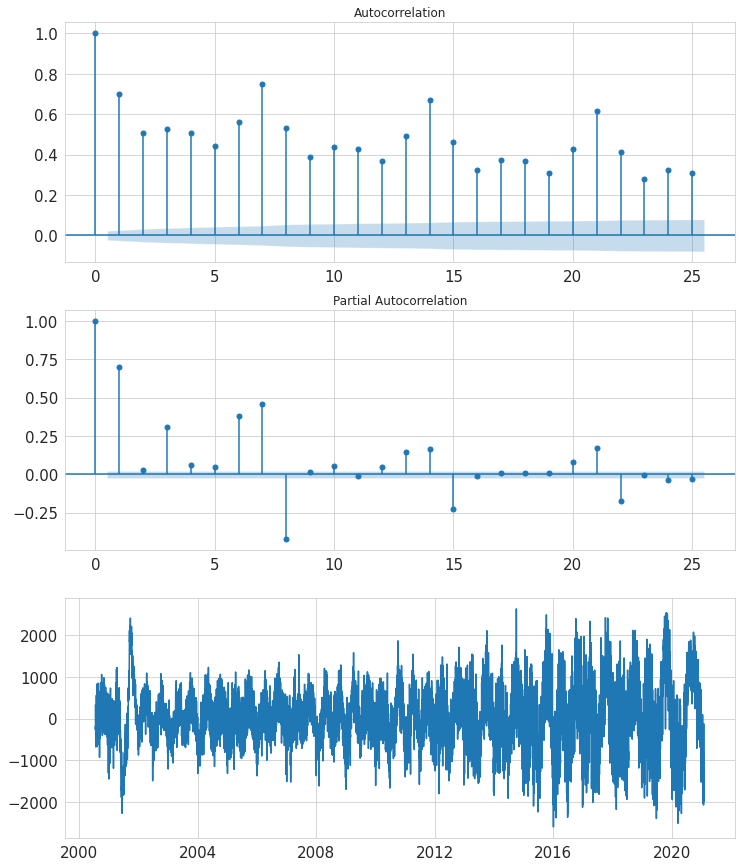

In [29]:
# dados estacionários (tentativa, mas não dá)
stationary = data['value'] - data['value'].rolling(100).mean()
fig, ax = plt.subplots(3, figsize=(12,15))
x = (stationary.dropna() - stationary.dropna().shift(100)).dropna()
ax[0] = plot_acf(x, ax=ax[0], lags=25)
ax[1] = plot_pacf(x, ax=ax[1], lags=25)
ax[2].plot(x)

# 2.1 Autocorreção com os dados de diferenciação

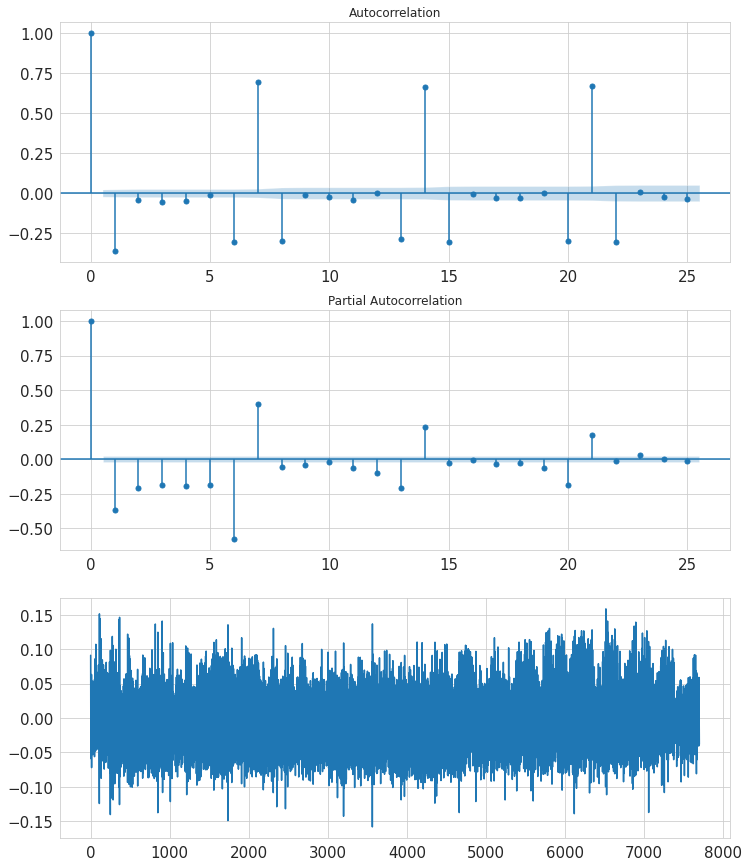

In [30]:
_, ax = plt.subplots(3, figsize=(12,15))
ax[0] = plot_acf(v_log_diff, ax=ax[0], lags=25)
ax[1] = plot_pacf(v_log_diff, ax=ax[1], lags=25)
ax[2].plot(v_log_diff)

# 3. ARIMA

## 3.1 Tratando os dados internos

In [31]:
split_date = '1/1/2020 12:00:00 AM'
test  = data[split_date : ]
train = data[ : split_date]

train = train['value']
test = test['value']
series = pd.concat([train, test], axis=0)

series

index
2000-01-01     6205.000
2000-01-02     6797.000
2000-01-03     7024.000
2000-01-04     6921.000
2000-01-05     7025.000
                ...    
2021-01-27    12308.892
2021-01-28    12550.095
2021-01-29    12413.574
2021-01-30    11988.032
2021-01-31    11540.266
Name: value, Length: 7702, dtype: float64

## 3.2 Métodos para treinamento

In [32]:
# Mostrar previsão de acordo com os dados originais
def plot_forecasts(series, forecasts, test):
	plt.plot(series) # blue

	# Colocando no gráfico as previsões com a cor vermelha
	for i in range(len(forecasts)):
        # Inicio e fim dos dos deslocamentos por x
		off_s = len(series) - len(test) + i - 1
		off_e = off_s + len(forecasts[i]) + 1
		xaxis = [x for x in range(off_s, off_e)]

        # Valores dos multiplos passos de previsão
		yaxis = [series[off_s]] + forecasts[i]
		plt.plot(xaxis, yaxis, color='red')

	# Gráfico
	plt.show()

# Salvar predições, excedentes e erros
def save_results_file(test, forecasts, n_steps):
	predictions = {}
	expected = {}
	erros = {}
	for i in range(n_steps):
		# Pegando os valores de multiplos passos de previsão
		ypred_ts = [forecast[i] for forecast in forecasts]
		# Salvando previsão
		predictions['t+' + str(i+1)] = ypred_ts
		ytrue_ts = test[i:len(ypred_ts)+i]
		ytrue_ts_lst = [i for i in ytrue_ts]

		# Salvando excedente
		expected['t+' + str(i+1)] = ytrue_ts_lst

		# Calculando e salvando erro
		erro = sqrt(mean_squared_error(ytrue_ts, ypred_ts))
		erros['t+' + str(i+1)] = erro

	with open('data/retrain/daily_demand_predictions_arima.txt', 'w') as output:
		for k, v in predictions.items():
			output.write(str(k)+'\n')
			output.write(str(v)+'\n')

	with open('data/retrain/daily_demand_expected_arima.txt', 'w') as output:
		for k, v in expected.items():
			output.write(str(k)+'\n')
			output.write(str(v)+'\n')

	with open('data/retrain/daily_demand_errors_arima.txt', 'w') as output:
		for k, v in erros.items():
			output.write(str(k)+'\n')
			output.write(str(v)+'\n')

# Avaliação de erro do ARIMA
def evaluate_forecasts(test, forecasts, n_steps):
    sum_rmse = 0
    sum_mape = 0
    sum_aic = 0
    for i in range(n_steps):
        ypred_ts = [forecast[i] for forecast in forecasts]
        ytrue_ts = test[i:len(ypred_ts)+i]
        # Calculando os erros
        mape = mean_absolute_percentage_error(ytrue_ts, ypred_ts)*100
        rmse = sqrt(mean_squared_error(ytrue_ts, ypred_ts))
        aic_error = aic.aic(ytrue_ts, ypred_ts, 4)
        sum_rmse += rmse
        sum_mape += mape
        sum_aic += aic_error
        print(f"t+{(i+1)} RMSE: {rmse} | MAPE: {mape} | AIC: {aic_error}")

    # média dos erros
    print(f"Média do RMSE: {sum_rmse/n_steps}")
    print(f"Média do MAPE: {sum_mape/n_steps}")
    print(f"Média do AIC: {sum_aic/n_steps}")

# Treinamento de previsão por ARIMA por multiplos passos
def arima_forecast(train, config, n_steps):
	p, d, q = config
	# Definindo e moldando o modelo
	model = ARIMA(train, order=(p,d,q), trend=None, trend_offset=1)
	model_fit = model.fit()

	# Fazendo previsão com multiplos passos
	yhat = model_fit.predict(len(train), len(train)+n_steps-1)
	yhat_list = [value for value in yhat]

	return yhat_list

## 3.3 Treinamento e resultado

t=(390 de 391) -> Predito=11986.895323, Esperado=12271.288000
Ultimos 10 valores:
Predito=[12255.516950829544, 12368.587347500106, 12394.036290825517, 12398.498386070305, 12399.108079230964, 12399.161149836216, 12399.158974900218], Esperado=12115.408
Predito=[12308.070517728624, 12362.65959708422, 12373.772403869916, 12375.563099338031, 12375.780571503086, 12375.793448126671, 12375.79079102314], Esperado=11904.916
Predito=[12188.50203472083, 12283.384986505966, 12304.362199168158, 12308.020852153086, 12308.52424416593, 12308.570009102861, 12308.56897488748], Esperado=12622.064
Predito=[12470.581239848667, 12401.470415641437, 12384.5425258586, 12381.372657182646, 12380.90068771361, 12380.85022702973, 12380.848891298656], Esperado=12365.629
Predito=[12356.17626608646, 12361.04283978598, 12362.84788816479, 12363.262290111117, 12363.336472424395, 12363.346970681585, 12363.347983021677], Esperado=12258.734
Predito=[12318.987916190932, 12341.030559352272, 12346.064614554902, 12346.9617376818

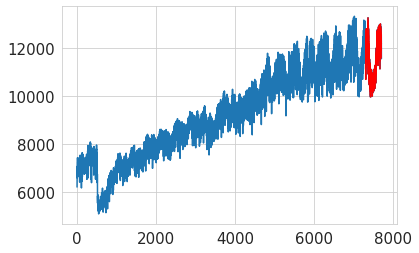

In [33]:
test = test.values
series = series.values
train = [x for x in train]

n_steps = 7

# configurações da previsão ARIMA
p_param = 2
d_param = 1
q_param = 1
config = [p_param, d_param, q_param]

# lista para armazenar os paços de predição e a quantidade de predições a frente
forecasts = list()
forecasts_exp = list()
n_forecasts = len(test) - n_steps + 1

for i in range(n_forecasts):
    yhat = arima_forecast(train, config, n_steps)
    # adicionando valor de predição a lista
    forecasts.append(yhat)
    # Adicionando valor de previsão pelo treino para o proximo loop
    obs = test[i]
    train.append(obs)
    forecasts_exp.append([yhat, obs])
    stdout.write("\rt=(%i de %i) -> Predito=%f, Esperado=%f" % (i, n_forecasts, yhat[0], obs))

print("\nUltimos 10 valores:")
for item in forecasts_exp[-10:]:
    print(f"Predito={item[0]}, Esperado={item[1]}")

# Salvar predições, excedentes e erros
save_results_file(test, forecasts, n_steps)
# Avaliação da previsão
evaluate_forecasts(test, forecasts, n_steps)
# Mostrar previsão
plot_forecasts(series, forecasts, test)